In [1]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker,SafeMaskMaker
from gammapy.irf import EDispKernel
from gammapy.makers.utils import make_psf_map
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)
from gammapy.modeling import Fit

1.0


In [2]:
import os
os.chdir('../EventDataset/')
from EventDatasetMaker import EventDatasetMaker
from EventDataset import EventDataset

In [3]:
%load_ext autoreload
%autoreload 2

## Set up a binned and unbinned Dataset

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [5]:
## define the geometry
nebins = 20
binsz = 0.02*u.deg

crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.geomspace(1,100,nebins)
energy_axis = MapAxis.from_edges(
    ebins[:-1], unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=binsz,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [6]:
%%time
maker = MapDatasetMaker(selection=["counts", 'exposure','edisp', 'background', 'psf'])
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg', bias_percent=8)

reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model

CPU times: user 1.04 s, sys: 100 ms, total: 1.14 s
Wall time: 6.27 s


In [83]:
%%time
test_maker = EventDatasetMaker(safe_mask_maker=maker_safe_mask, selection=None)
eds = test_maker.run(reference, obs1)

bkg_model2 = FoVBackgroundModel(dataset_name=eds.name)
eds.models=bkg_model2

CPU times: user 804 ms, sys: 46.4 ms, total: 850 ms
Wall time: 3.63 s


In [84]:
model_gauss = SkyModel(
    spatial_model=PointSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", frame = 'galactic'),
    spectral_model=PowerLawSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=2.0, 
                                         ),
    name='crab_model'
    )
model_gauss.spatial_model.parameters.freeze_all()
dataset.models = [bkg_model,model_gauss]
eds.models = [bkg_model2,model_gauss.copy(name="crab_model")]

# to make it fair set the same binsz
eds.evaluators['crab_model'].spatialbs = binsz

In [85]:
## need to monkey patch the paramter_norm_only_changed methods 
## because otherwise a simple rescaling would happen
@property
def pnoc_patch(self):
    """Only norm parameter changed"""
    norm_only_changed = False
    return norm_only_changed


# disable caching
ev_ds=dataset.evaluators['crab_model']
ev_eds=eds.evaluators['crab_model']
ev_ds.use_cache = False
ev_eds.use_cache = False
# at the moment parameter_norm_only_changed return False always
# if that is fixed we would need to monkey patch it
# this is hard because it is @property decorated so better patch _compute_npred()

In [99]:
%prun -s cumtime eds.stat_sum()

using bkg cache
 

In [101]:
ev_eds.geom

WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (10, 10, 19)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 0.2 deg x 0.2 deg
	wcs ref    : 83.6 deg, 21.5 deg

## Timing

In [102]:
sampler = MapDatasetEventSampler(random_state=0)

In [103]:
obs_time = obs1.observation_time_duration
exposure_obs = dataset.exposure.copy()
obs_time

<Quantity 1687. s>

In [110]:
%%time
times_bin = Table(names = ['n_events','mean', 'std', 'sim_time'])
times_unb = Table(names = ['n_events','mean', 'std', 'sim_time'])
for sim_time in [0.5,1,2,4,8,16]*u.h:
# sim_time = 2*u.h
    rescale = (sim_time / obs_time).to_value('')
    dataset.exposure.data = exposure_obs.data * rescale
    dataset.background_model.parameters['norm'].value = rescale
    dataset.evaluators['crab_model'].update(dataset.exposure, 
                                            dataset.psf, 
                                            dataset.edisp, 
                                            dataset._geom, 
                                            dataset.mask_image)

    events = sampler.run(dataset, obs1)
    dataset.counts.data *= 0
    dataset.counts.fill_events(events)
    eds.events = events
    eds.evaluators['crab_model'].exposure = None # force update
    eds._response_bkg_cached = None

    # calculate the stat_sum once for both
    print(eds.stat_sum())
    print(dataset.stat_sum())

    n_events_unb = len(eds.events_in_mask.table)
    n_events_bin = np.sum(dataset.counts.data[dataset.mask])
    if n_events_unb != n_events_bin:
        print(sim_time,n_events_unb,n_events_bin)

    time_bin = %timeit -n10 -r3 -o dataset.stat_sum()
    time_unb = %timeit -n10 -r3 -o eds.stat_sum()

    result_bin = {'n_events':n_events_bin, 
                  'mean':time_bin.average, 
                  'std':time_bin.stdev,
                  'sim_time': sim_time}
    result_unb = {'n_events':n_events_unb, 
                  'mean':time_unb.average, 
                  'std':time_unb.stdev,
                  'sim_time': sim_time}
    times_bin.add_row(result_bin)
    times_unb.add_row(result_unb)

-30079.18051312092
16221.930127176096
22.5 ms ± 333 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
5.54 ms ± 142 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-70452.9166190179
28762.325276907413
21.8 ms ± 424 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
6.45 ms ± 75.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-149516.69477800519
49141.397978881
21.1 ms ± 352 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
9.41 ms ± 268 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-300387.28564398864
80456.47362030038
20.8 ms ± 130 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
15.7 ms ± 118 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-608082.4354969983
126842.57648153834
20.9 ms ± 123 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
35.2 ms ± 55.8 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-1243487.5020924162
190071.37194115002
23 ms ± 187 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
65.8 ms ± 1.43 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
CPU times: user 39.6 s, sys: 8.96 s, total: 48.5 s
Wall time: 58 s


Text(0.5, 0, 'Number of events')

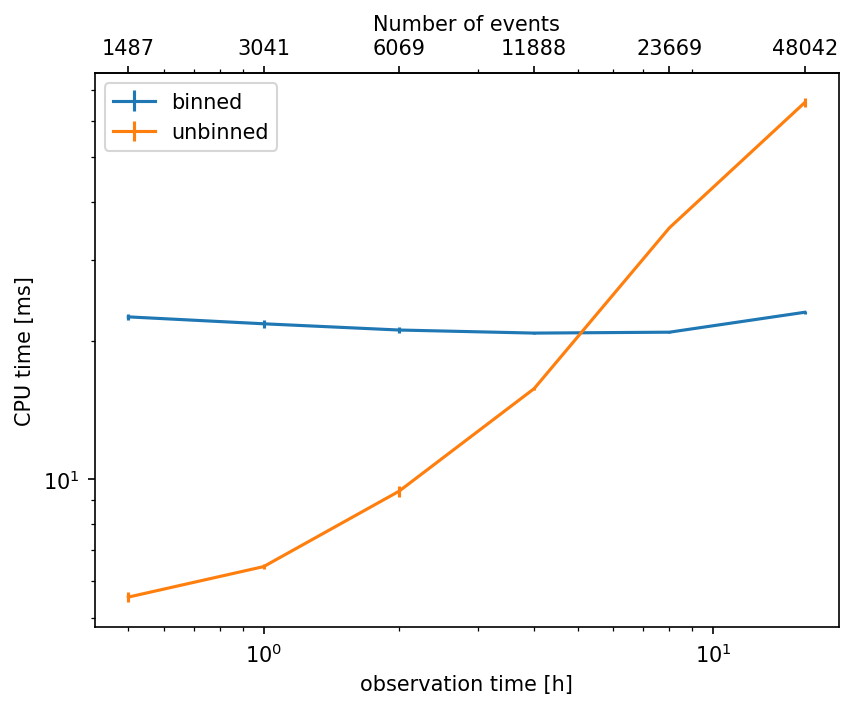

In [112]:
fig, ax = plt.subplots(dpi=150)
time_fac = 1e3 # ms
ax.errorbar(times_bin['sim_time'], 
            times_bin['mean']*time_fac, yerr=times_bin['std']*time_fac, 
            label='binned')
ax.errorbar(times_unb['sim_time'], 
            times_unb['mean']*time_fac, yerr=times_unb['std']*time_fac, 
            label='unbinned')
ax.legend()
ax.set_xlabel('observation time [h]')
ax.set_ylabel('CPU time [ms]')
ax.loglog()

ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(times_unb['sim_time'], labels=times_unb['n_events'].astype(int))
ax2.set_xlabel('Number of events')